# 1 Complete Dictionary Learning
## 1.1 Experimental Validation

In [6]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import generator

%config InlineBackend.figure_format='retina'

In [7]:
def four_norm_maximization_generator(size):
    current = generator.get_random_orthogonal(size)
    yield current
    while True:
        delta_current = current * current * current
        left, _, right = np.linalg.svd(delta_current, compute_uv=True)
        projection = left @ right
        current = projection
        yield current

In [8]:
def dictionary_learning_generator(observations):
    current = generator.get_random_orthogonal(len(observations))
    yield current
    while True:
        matched = current @ observations
        delta_current = (matched * matched * matched) @ observations.T
        left, _, right = np.linalg.svd(delta_current, compute_uv=True)
        projection = left @ right
        current = projection
        yield current

### 1.1.1 $\ell^4$-maximization on Orthogonal Group

In [11]:
ITERATIONS = 15
SIZE = 100

objective_values = []

updates = four_norm_maximization_generator(SIZE)
for current in itertools.islice(updates, ITERATIONS):
    value = generator.sum_of_fourth_powers(current) / SIZE
    objective_values.append(value)

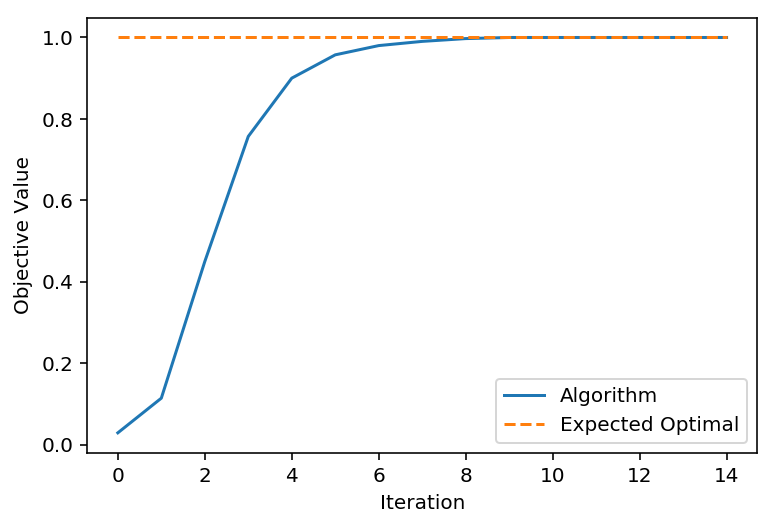

In [12]:
scale = np.arange(ITERATIONS)
plt.plot(scale, objective_values)
plt.plot(scale, np.ones(ITERATIONS), linestyle='--')

plt.xlabel('Iteration')
plt.ylabel('Objective Value')
plt.legend(['Algorithm', 'Expected Optimal'])
plt.show()

### 1.1.2 Dictionary Learning via the MSP Algorithm

In [13]:
FEATURES = 100
SAMPLES = 40000
THETA = 0.3
ITERATIONS = 30

observations, true_dictionary, true_samples = \
    generator.random_dictionary_learning_instance(
        FEATURES, SAMPLES, THETA)

In [14]:
observation_matches = []
true_matches = []

updates = dictionary_learning_generator(observations)
for current in itertools.islice(updates, ITERATIONS):
    value = generator.sum_of_fourth_powers(current @ observations) 
    value /= (3 * FEATURES * SAMPLES * THETA)
    observation_matches.append(value)

    value = generator.sum_of_fourth_powers(current @ true_dictionary)
    value /= SIZE
    true_matches.append(value)

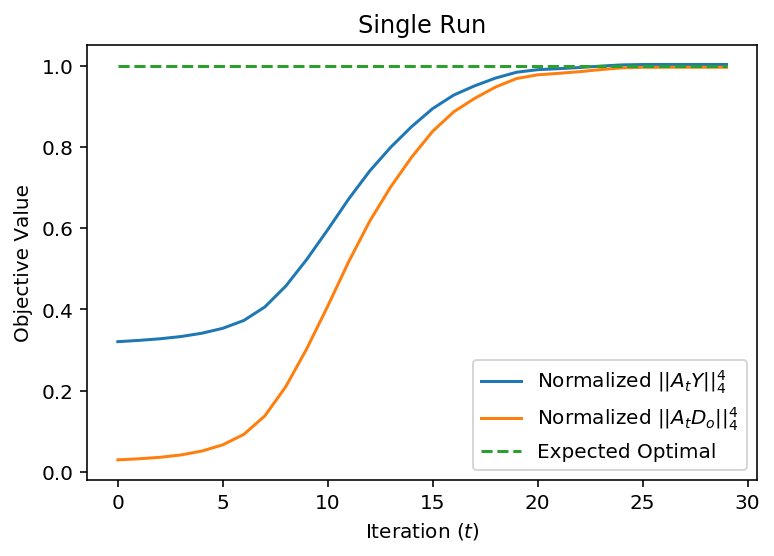

In [16]:
scale = np.arange(ITERATIONS)
plt.plot(scale, observation_matches)
plt.plot(scale, true_matches)
plt.plot(scale, np.ones(ITERATIONS), linestyle='--')

plt.title('Single Run')
plt.xlabel('Iteration ($t$)')
plt.ylabel('Objective Value')
plt.legend(['Normalized $|| A_t Y||_4^4$', 'Normalized $|| A_t D_o||_4^4$', 'Expected Optimal'])
plt.show()

In [32]:
REPITITIONS = 20
observation_matches = np.zeros((REPITITIONS, ITERATIONS))
true_matches = np.zeros((REPITITIONS, ITERATIONS))

for rep in range(REPITITIONS):
    # Create Problem Instance
    observations, dictionary, _ = generator.random_dictionary_learning_instance(
        FEATURES, SAMPLES, THETA)
    
    # Solve, Keeping Track of Iteration Values
    updates = dictionary_learning_generator(observations)
    for timestep, current in zip(range(ITERATIONS), updates):
        value = generator.sum_of_fourth_powers(current @ observations)
        value /= (3 * FEATURES * SAMPLES * THETA)
        observation_matches[rep][timestep] = value

        value = generator.sum_of_fourth_powers(current @ dictionary)
        value /= SIZE
        true_matches[rep][timestep] = value

In [41]:
print(observation_matches.shape, true_matches.shape)

observation_means = observation_matches.mean(axis=0)
observation_errs = np.std(observation_matches, axis=0)
true_means = true_matches.mean(axis=0)
true_errs = np.std(true_matches, axis=0)

(20, 30) (20, 30)


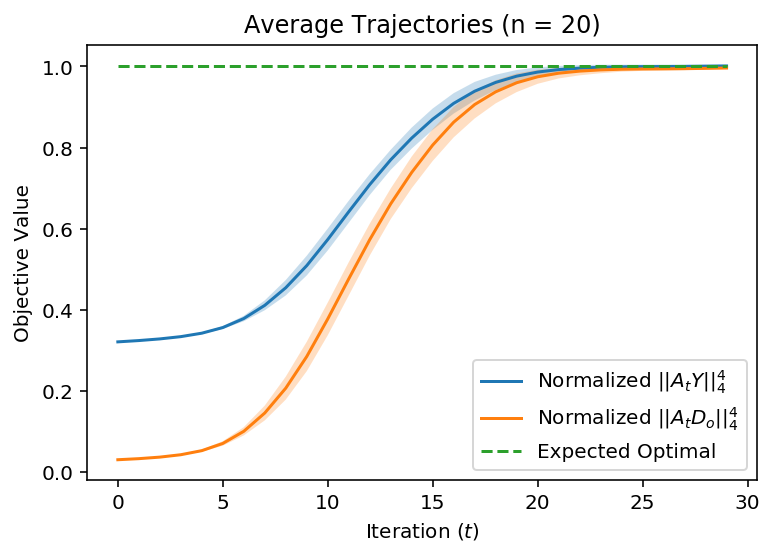

In [47]:
scale = np.arange(ITERATIONS)

plt.plot(scale, observation_means)
plt.fill_between(
    scale,
    observation_means - observation_errs,
    observation_means + observation_errs,
    alpha=0.25)
plt.plot(scale, true_means)

plt.fill_between(
    scale,
    true_means - true_errs,
    true_means + true_errs,
    alpha=0.25)
plt.plot(scale, np.ones(ITERATIONS), linestyle='--')

plt.title('Average Trajectories (n = {})'.format(REPITITIONS))
plt.xlabel('Iteration ($t$)')
plt.ylabel('Objective Value')
plt.legend(['Normalized $|| A_t Y||_4^4$', 'Normalized $|| A_t D_o||_4^4$', 'Expected Optimal'])
plt.show()